In [27]:
%run "./0. Download HCP Task Dataset.ipynb"

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [29]:
HCP_DIR = "./hcp_task"

TIME_RESOLUTION = 0.72  # fMRI time resolution, in seconds.

# These could be read from file, but they're constants so lets treat them as such:
DATA_LENGTH = 176
DURATION = 18.0

OFFSET = 5 # Offset each condition by this to account for BOLD signal delay. 

In [30]:
subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')
regions = np.load(f"{HCP_DIR}/regions.npy").T

In [31]:
# Helper functions.
def load_timeseries(file_path, return_region_dict = False, remove_mean = True):
    ts = np.load(file_path)
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)

    if (return_region_dict):
        return_dict = {}
        for i in range(len(regions[0])):
            return_dict[regions[0][i]] = ts[i]
        return return_dict
    
    return ts

def load_evs(ev_directory):
    neut = np.loadtxt(f"{ev_directory}/neut.txt", ndmin=2, unpack=True)
    neut_onset = neut[0]

    fear = np.loadtxt(f"{ev_directory}/fear.txt", ndmin=2, unpack=True)
    fear_onset = fear[0]

    # Combine the neut_onset and fear_onset into an array and sort it by onset. 
    combined = [("Neut", onset) for onset in neut_onset] + [("Fear", onset) for onset in fear_onset]
    _sorted = sorted(combined, key=lambda x: x[1])

    return_array = []
    for condition, onset in _sorted:
        
        # Use onset and duration to index into the data array. 
        start_frame = np.floor(onset / TIME_RESOLUTION).astype(int)
        end_frame = start_frame + np.ceil(DURATION / TIME_RESOLUTION).astype(int)

        # Add our bold-signal delay offset.
        start_frame = start_frame + OFFSET
        end_frame = end_frame + OFFSET

        # The last three trials of the last block were not recorded, so we truncate this block to prevent index out of range.  
        if (end_frame >= DATA_LENGTH):
            end_frame = DATA_LENGTH

        return_array.append({
            "Condition": condition,
            "Onset": onset,
            "Duration": DURATION,
            "Frames": (start_frame, end_frame)
        })

    return return_array


In [32]:
# Create full data structure. 
manifest = {}
for subject_id in subjects:
     
    if subject_id not in manifest:
        manifest[subject_id] = []
            
    for trial_index, trial in enumerate(["LR", "RL"]):
        data_path = f"{HCP_DIR}/subjects/{subject_id}/EMOTION/tfMRI_EMOTION_{trial}/data.npy"
        ev_path = f"{HCP_DIR}/subjects/{subject_id}/EMOTION/tfMRI_EMOTION_{trial}/EVs"

        time_series = load_timeseries(data_path)
        region_time_series = load_timeseries(data_path, return_region_dict=True)
        condition_data = load_evs(ev_path)

        manifest[subject_id].append({
            "data": time_series,
            "region_data": region_time_series,
            "condition_spans": condition_data
        })

Subject 0: 100307
	Trial: 1
		Block 1: Neut condition starts at 10.982 and runs for 18.0 containing frames: (20, 45)
		Block 2: Fear condition starts at 32.053 and runs for 18.0 containing frames: (49, 74)
		Block 3: Neut condition starts at 53.125 and runs for 18.0 containing frames: (78, 103)
		Block 4: Fear condition starts at 74.196 and runs for 18.0 containing frames: (108, 133)
		Block 5: Neut condition starts at 95.267 and runs for 18.0 containing frames: (137, 162)
		Block 6: Fear condition starts at 116.338 and runs for 18.0 containing frames: (166, 176)


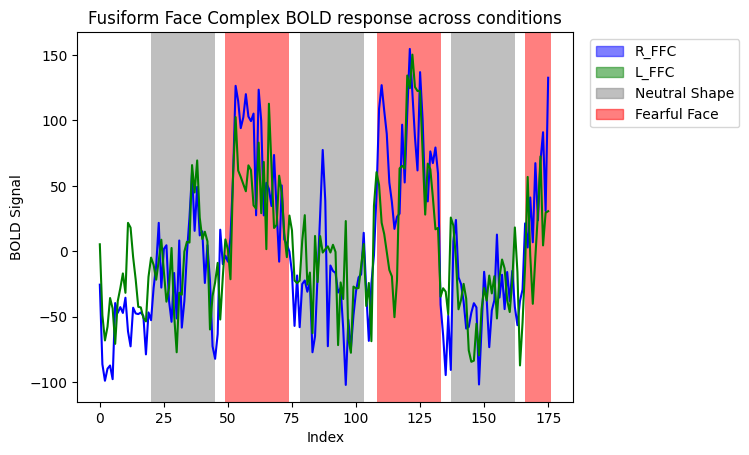

In [33]:
# Plot the first subject's FFC.
for subject_index, subject_id in enumerate(subjects):
    print(f"Subject {subject_index}: {subject_id}")
    
    for trial_index, trial in enumerate(manifest[subject_id]):
        print(f"\tTrial: {trial_index + 1}")

        plt.plot(trial["region_data"]["R_FFC"], color="blue")
        plt.plot(trial["region_data"]["L_FFC"], color="green")

        condition_patches = [
            mpatches.Patch(color="blue", alpha=0.5), 
            mpatches.Patch(color="green", alpha=0.5), 
            mpatches.Patch(color="gray", alpha=0.5), 
            mpatches.Patch(color="red", alpha=0.5)
            ]
        condition_labels = ["R_FFC", "L_FFC", "Neutral Shape", "Fearful Face"]

        for block_index, condition_dict in enumerate(trial["condition_spans"]): 
            print(f"\t\tBlock {block_index + 1}: {condition_dict['Condition']} condition starts at {condition_dict['Onset']} and runs for {condition_dict['Duration']} containing frames: {condition_dict['Frames']}")

            start_index = condition_dict['Frames'][0]
            end_index = condition_dict['Frames'][1]

            if condition_dict['Condition'] == "Neut":
                plt.axvspan(start_index, end_index, facecolor="gray", alpha=0.5)

            if condition_dict['Condition'] == "Fear":
                plt.axvspan(start_index, end_index, facecolor="red", alpha=0.5)

        plt.title('Fusiform Face Complex BOLD response across conditions')
        plt.xlabel('Index')
        plt.ylabel('BOLD Signal')

        plt.legend(handles=condition_patches, labels=condition_labels, bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.show()

        break
    break

In [40]:
# Prepare the data for modeling:
X = []
Y = []

for subject_index, subject_id in enumerate(subjects):
    for trial_index, trial in enumerate(manifest[subject_id]):
        for block_index, condition_dict in enumerate(trial["condition_spans"]): 

            # To ensure data balance, we drop the last block of each condition... 
            # Todo: Find a more sophisticated approach to handling the data imbalance.  
            if (block_index+1 == 5 or block_index+1 == 6):
                break

            start_index = condition_dict['Frames'][0]
            end_index = condition_dict['Frames'][1]
            
            x = trial["data"][:, start_index : end_index]
            y = 0 if condition_dict['Condition'] == "Neut" else 1

            X.append(x)
            Y.append(y)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(800, 360, 25)
(800,)
